# import libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import h2o 


In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# print the shape of the data
print("Train data rows: ", df_train.shape[0], " and columns: ", df_train.shape[1])
print("Test data rows: ", df_test.shape[0], " and columns: ", df_test.shape[1])

df_train.head()

Train data rows:  630000  and columns:  15
Test data rows:  270000  and columns:  14


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [6]:
# remove id column
df_train = df_train.drop(columns=['id'])

In [7]:
target_col = 'Heart Disease'
numerical_features = ["Age", "BP", "Cholesterol", "Max HR", "ST depression"]
categorical_features = ["Sex", "Chest pain type", "FBS over 120", "EKG results", 
                        "Exercise angina", "Slope of ST", "Number of vessels fluro",
                       "Thallium"]

# Exploratory Data Analysis

In [8]:
# check missing values
print("Missing values count: ", df_train.isnull().sum().sum(), "\n")

# check duplicates
print("Duplicates count: ", df_train.duplicated().sum(), "\n")

Missing values count:  0 

Duplicates count:  0 



In [9]:
# print unique values in numerical features
print(df_train[numerical_features].nunique(), "\n")

# print unique values in categorical features
print(df_train[categorical_features].nunique(), "\n")

Age               42
BP                66
Cholesterol      150
Max HR            93
ST depression     66
dtype: int64 

Sex                        2
Chest pain type            4
FBS over 120               2
EKG results                3
Exercise angina            2
Slope of ST                3
Number of vessels fluro    4
Thallium                   3
dtype: int64 



## Univariate EDA

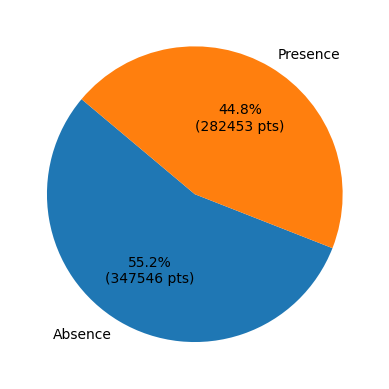

In [10]:
# plot the distribution of the target variable, pie chart
counts = df_train[target_col].value_counts()

plt.pie(
    counts, 
    labels=counts.index, 
    autopct=lambda p: f'{p:.1f}%\n({int(p*sum(counts)/100)} pts)',
    startangle=140
)
plt.show()

In [ ]:
# show label for each gender


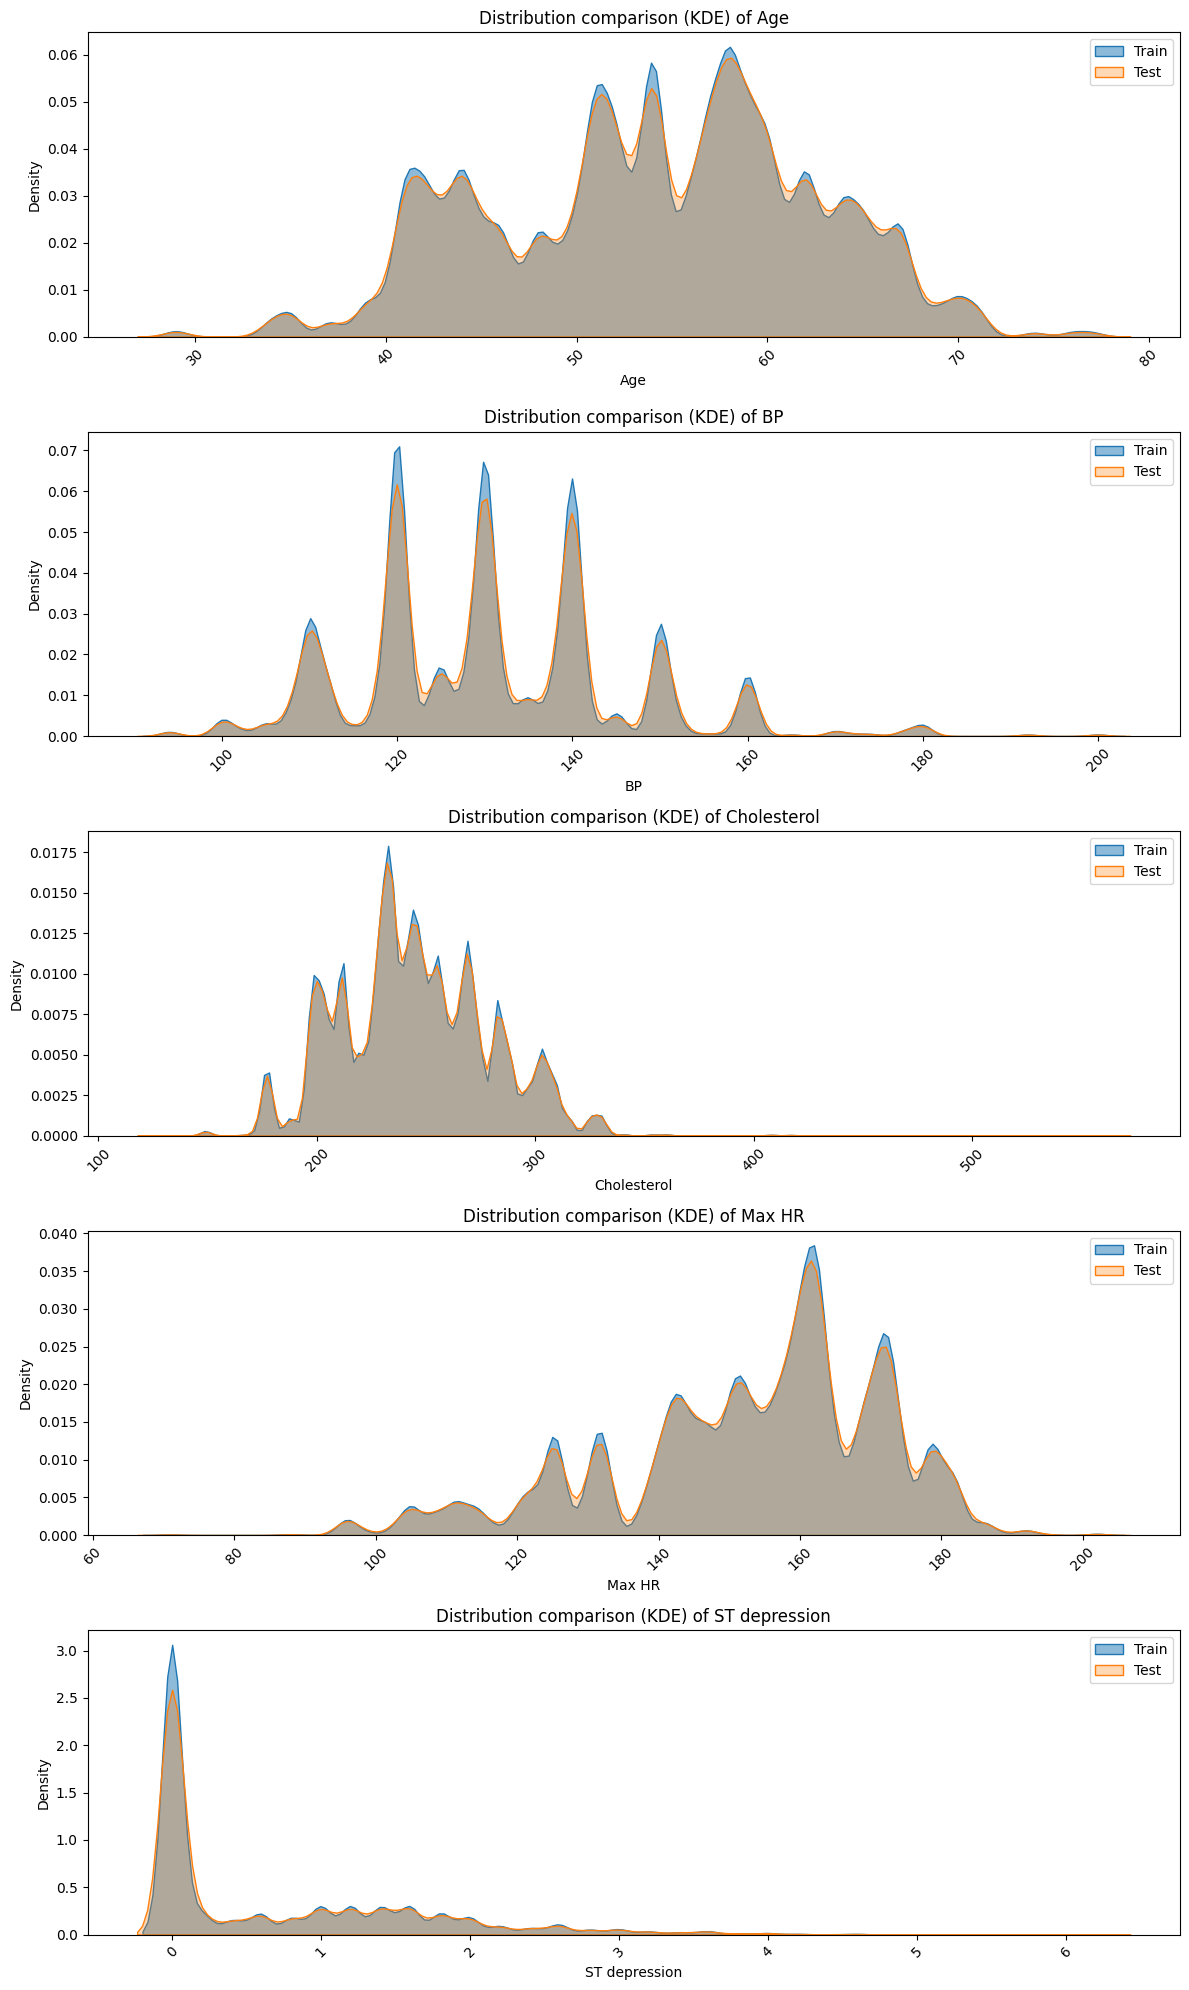

In [11]:
num_features = len(numerical_features)
fig, axes = plt.subplots(num_features, 1, figsize=(12, 4*num_features))

for ax, column in zip(axes, numerical_features):
    sns.kdeplot(df_train[column], ax=ax, label='Train', fill=True, alpha=0.5)
    sns.kdeplot(df_test[column], ax=ax, label='Test', fill=True, alpha=0.3)
    ax.set_title(f'Distribution comparison (KDE) of {column}')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Feature Selection

In [29]:
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.481-b10, mixed mode)
  Starting server from C:\Users\muaz\AppData\Roaming\Python\Python313\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\muaz\AppData\Local\Temp\tmpn3am1uq8
  JVM stdout: C:\Users\muaz\AppData\Local\Temp\tmpn3am1uq8\h2o_muaz_started_from_python.out
  JVM stderr: C:\Users\muaz\AppData\Local\Temp\tmpn3am1uq8\h2o_muaz_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,2 months and 12 days
H2O_cluster_name:,H2O_from_python_muaz_jwsih4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8.86 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
23:11:44.148: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
23:11:44.156: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Best model: StackedEnsemble_AllModels_1_AutoML_1_20260205_231144
Validation AUC: 0.9548620792436716


C:\Users\muaz\AppData\Roaming\Python\Python313\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


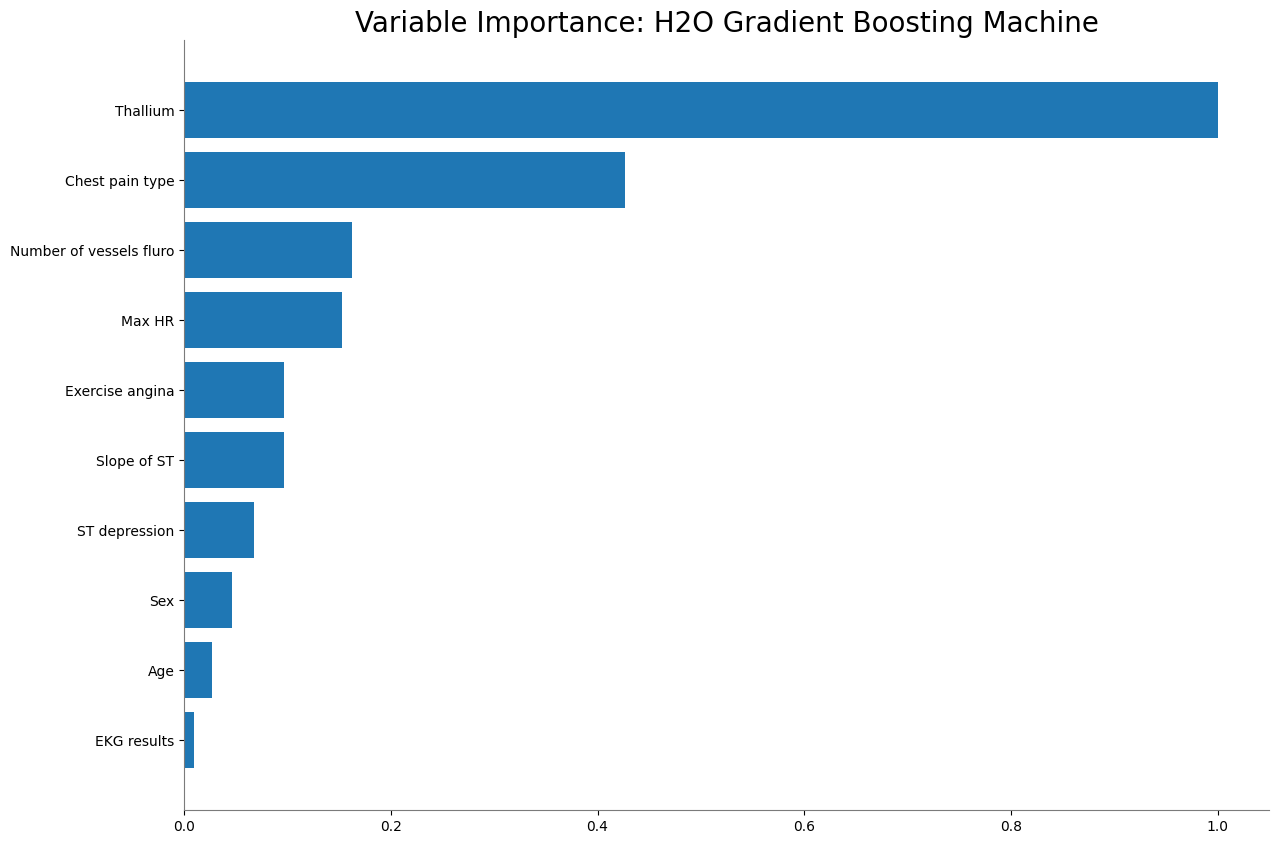

<Figure size 640x480 with 0 Axes>

In [31]:
# H2O AutoML: train, select best model, and plot feature importance

# Convert pandas DataFrame to H2OFrame
hf = h2o.H2OFrame(df_train)

# Define response and predictors
y = target_col
x = [col for col in hf.columns if col != y]

# Classification: make the response categorical
hf[y] = hf[y].asfactor()

# Train/validation split for model selection
train, valid = hf.split_frame([0.8], seed=1)

# Run H2O AutoML
aml = H2OAutoML(max_models=10, seed=1, sort_metric="AUC", nfolds=5)
aml.train(x=x, y=y, training_frame=train, validation_frame=valid)

# Leaderboard of models
lb = aml.leaderboard
lb.head(rows=10)

# Get the best overall model
best_model = aml.leader
print("Best model:", best_model.model_id)

# Evaluate best model on validation data
perf_valid = best_model.model_performance(valid)
print("Validation AUC:", perf_valid.auc())

# If leader is an ensemble without varimp, pick a tree model from leaderboard
lb_df = lb.as_data_frame()

# Try to find a GBM/XGBoost model for variable importance
tree_model_id = None
for algo_keyword in ["GBM", "XGBoost"]:
    candidates = lb_df[lb_df["model_id"].str.contains(algo_keyword, na=False)]["model_id"]
    if not candidates.empty:
        tree_model_id = candidates.iloc[0]
        break

if tree_model_id is not None:
    tree_model = h2o.get_model(tree_model_id)
    tree_model.varimp_plot()
else:
    # Fall back to leader if it supports varimp
    try:
        best_model.varimp_plot()
    except Exception as e:
        print("Variable importance not available for the leader model:", e)